In [0]:
# for coloab only
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/CE - ML &Deep Learning/Machine Learning/Lab 3'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
print('tensorfolw las version :  1.14.0')

tensorfolw las version :  1.14.0


In [0]:
pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorflow-estimator, astor, numpy, google-pasta, grpcio, six, absl-py, tensorboard, wheel, termcolor, wrapt, gast, protobuf, keras-applications, keras-preprocessing
Required-by: talos, fancyimpute


In [0]:
# pip install tensorflow
!pip install talos

# ตอนที่ 1  การทดลองเตรียมข้อมูล ปรับค่าข้อมูล และจัดแบ่งชุด Train, Test เพื่อสอนโมเดล

### Import Lib (numpy, pandas, matplotlib, sklearn, keras)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import talos as ta

plt.style.use('ggplot')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### โหลดข้อมูล Timeseries Dataset file 

In [0]:
# num_name = ['46343', '759667', '781756', '844359', '1066528']
# num_name = ['46343', '844359']
# fea_name = [ 'acceleration', 'heartrate', 'steps', 'labeled_sleep']

num_name = ['46343', '781756', '1066528', '844359']
fea_name = [ 'acceleration', 'heartrate', 'labeled_sleep']

df_list = list()
merge_fea_col = pd.DataFrame()

for n in num_name :
  fea_col = list()
  for idx_fea,f in enumerate(fea_name, 0): 
    fea_df = pd.read_csv(root_dir + '/Sleep_MiNiSet/' + n + '_' + f + '.txt', sep=" ", header=None)
    if len(fea_df.columns) < 2 :
      fea_df = pd.read_csv(root_dir + '/Sleep_MiNiSet/' + n + '_' + f + '.txt', sep=",", header=None)
    fea_df['uts_' + f] = pd.to_datetime(fea_df[0], unit='s', origin=pd.Timestamp('2019-10-04'))
    if len(fea_df.columns) <= 3 :
      fea_df.columns = ['time_sec_'+f , f, 'uts_' + f]
    else :
      fea_df.columns = ['time_sec_'+f , f+'_x', f+'_y', f+'_z', 'uts_' + f]  
    fea_col.append(fea_df)

  limit_sec = fea_col[len(fea_name) - 1].iloc[-1:, 0].values[0]
  for num_df in range(len(fea_name)) : 
    fea_col[num_df].set_index('uts_' + fea_name[num_df], inplace=True)
    fea_col[num_df] = fea_col[num_df][(fea_col[num_df]['time_sec_' + fea_name[num_df]] >= 0 ) & ( fea_col[num_df]['time_sec_' + fea_name[num_df]] <= limit_sec + 30)]
    fea_col[num_df] = fea_col[num_df].resample('30s').mean()
    fea_col[num_df].drop(fea_col[num_df].columns[0], axis=1, inplace=True)

  df_list.append(pd.concat([fea_col[0], fea_col[1], fea_col[2]], axis=1))

df_all = pd.concat([df_list[0], df_list[1], df_list[2], df_list[3]], sort=False)
df_all.columns = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'heartrate', 'labeled_sleep']
df_all.describe()

,acceleration_x,acceleration_y,acceleration_z,heartrate,labeled_sleep
count,3321.000000,3321.000000,3321.000000,3372.000000,3449.000000
mean,-0.133549,0.000816,-0.389406,62.807787,2.423021
std,0.291829,0.411056,0.749093,12.059878,1.719937
min,-0.719800,-0.992344,-0.990247,44.166667,-1.000000
25%,-0.337897,-0.277321,-0.928890,50.833333,1.000000
50%,-0.250326,-0.083415,-0.863242,62.000000,2.000000
75%,0.077588,0.244619,0.217862,71.166667,3.000000
max,0.655135,0.969157,0.962553,119.666667,5.000000


###  Preprocess data 

In [0]:
# reset index
df_all.reset_index(inplace=True)
df_all.columns = ['uts', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'heartrate', 'labeled_sleep']

before_clean_df = df_all

# drop duplicate
df_all.drop_duplicates(inplace=True)

# drop row that label = -1
df_all = df_all[df_all['labeled_sleep'] >= 0]

# fill null value with med
df_all.fillna(df_all.median()['acceleration_x': 'heartrate'], inplace=True)

# แทรกข้อมูลในช่วงเวลาที่ขาดหายไป
df_all.interpolate(method='slinear', inplace=True)

# จัดการลดสัญญาณรบกวนในข้อมูลด้วยการทำ Moving Average 
df_all.rolling(2).mean()

df_all.set_index('uts', inplace=True)
df_all.describe()

,acceleration_x,acceleration_y,acceleration_z,heartrate,labeled_sleep
count,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000
mean,-0.133636,-0.008592,-0.412472,62.657662,2.488771
std,0.287384,0.402671,0.738869,11.936547,1.669002
min,-0.719800,-0.992344,-0.990247,44.166667,0.000000
25%,-0.329852,-0.264263,-0.927952,50.958333,2.000000
50%,-0.245662,-0.090523,-0.867093,61.833333,2.000000
75%,0.065869,0.202203,0.160384,70.425000,5.000000
max,0.655135,0.969157,0.961169,119.666667,5.000000


In [0]:
# visual เปรียบเทียบข้อมูลก่อน Cleaning

before_clean_df.set_index('uts', inplace=True)
before_clean_df[before_clean_df.columns].plot(subplots=True, layout=(2, 3), figsize=(15,10))

g = sns.PairGrid(before_clean_df, hue='labeled_sleep')
g = g.map_offdiag(plt.scatter)
g = g.add_legend()
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)

SyntaxError: ignored

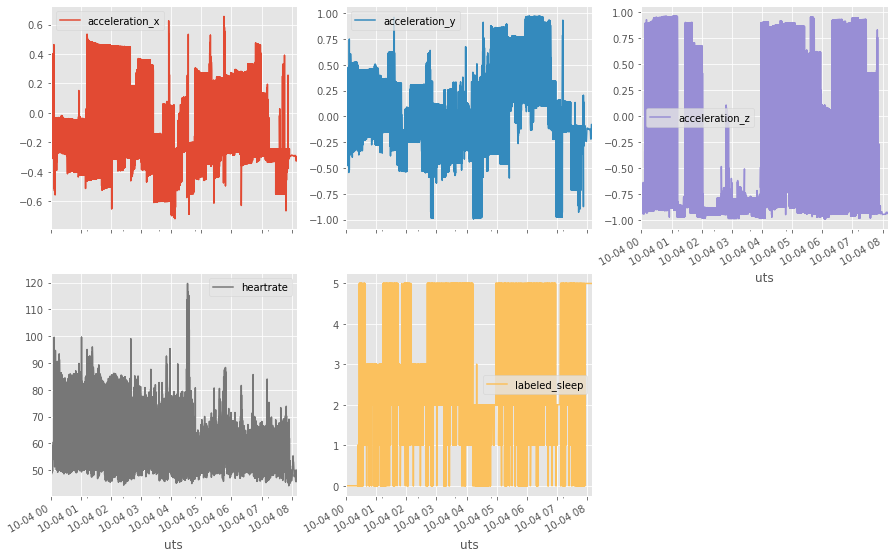

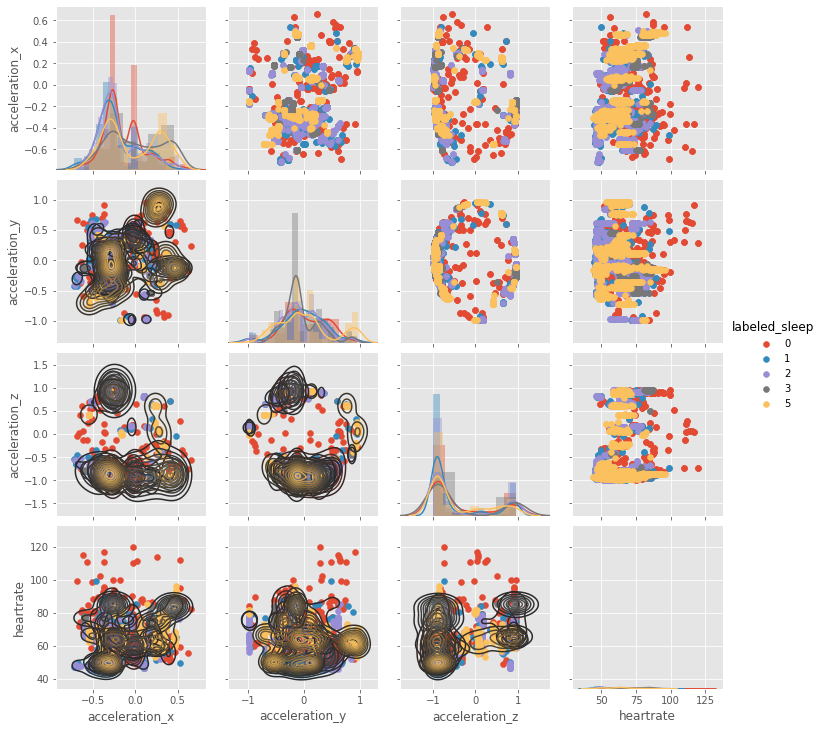

In [0]:
# visual เปรียบเทียบข้อมูลหลัง Cleaning

df_all[df_all.columns].plot(subplots=True, layout=(2, 3), figsize=(15,10))

g = sns.PairGrid(df_all, hue='labeled_sleep')
g = g.map_offdiag(plt.scatter)
g = g.add_legend()
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)

In [0]:
# ทำการ Normalize ข้อมูลด้วยเทคนิค Max-Min Norm
for column in df_all.loc[:, 'acceleration_x':'heartrate'].columns :
    df_all[column] = df_all.apply(lambda row: (row[column] - df_all[column].min()) / (df_all[column].max() - df_all[column].min()), axis=1)
df_all

,acceleration_x,acceleration_y,acceleration_z,heartrate,labeled_sleep
uts,,,,,
2019-10-04 00:06:30,0.152036,0.886849,0.333556,0.718322,0
2019-10-04 00:07:00,0.328352,0.663395,0.937100,0.734216,0
2019-10-04 00:07:30,0.276150,0.394882,0.964942,0.552192,0
2019-10-04 00:08:00,0.285619,0.366883,0.968591,0.493157,0
2019-10-04 00:08:30,0.310405,0.410171,0.968204,0.506780,0
...,...,...,...,...,...
2019-10-04 07:48:00,0.122254,0.213389,0.734448,0.305077,5
2019-10-04 07:48:30,0.038804,0.332573,0.518615,0.368653,0
2019-10-04 07:49:00,0.129526,0.319101,0.787589,0.392936,0


In [0]:
# สร้างฟังก์ชันสำหรับสร้าง TimeSeries
def process_create_WindowTimeSeries(df, activity_start, activity_len, time_window, n_feature, step_stride):
    df_series = df
    segments = []
    # วนลูปโดยให้ i มีค่าตั้งแต่ row ที่ 0 ถึง ( จำนวน row - time_window) โดยนับทีละ step_stride
    for i in range(0, len(df_series) - time_window, step_stride):
        
        # เก็บค่าของ row ที่ i ถึง i + time_window
        df_series_feature = df_series.iloc[i: i + time_window]   
        segments.append(np.array(df_series_feature))
        
    # ทำการ reshape ให้มีขนาด  ( #ชุด time_series, #time_step, #features ) 
    reshaped_segments = np.asarray(segments).reshape(-1, time_window, n_feature)

    return reshaped_segments

In [0]:
time_step = 3
time_stride = 1
col_name = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'heartrate', 'labeled_sleep']

time_series = process_create_WindowTimeSeries(df_all[col_name], 0, len(col_name), time_step, len(col_name), time_stride)
time_series_2d = time_series.reshape(time_series.shape[0]*time_series.shape[1],time_series.shape[2])

print(time_series.shape)
print('=================================')
print(time_series_2d.shape)

(3381, 3, 5)
(10143, 5)


### Prepare Label Ground Truth (y) 

In [0]:
# Init X
col_name = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'heartrate']
X = process_create_WindowTimeSeries(df_all[col_name], 0, len(col_name), time_step, len(col_name), time_stride)
X_2d = X.reshape(X.shape[0]*X.shape[1], X.shape[2])  # convert to 2D

print(X.shape)
print(X_2d.shape)

(3381, 3, 4)
(10143, 4)


In [0]:
# Majority vote prepare Label Ground Truth (y)

def majority_3d(time_series=time_series):
  mj_list = list()

  for t in range(time_series.shape[0]) :
    mj_vote = list()
    for r in range(time_series.shape[1]):
      mj_vote.append( time_series[t][r][time_series.shape[2] - 1] )
    mj_counter = Counter(mj_vote)
    mj_list.append(mj_counter.most_common(1)[0][0])
  return mj_list

def majority_2d(time_series=time_series_2d):
  mj_list = list()
  for r in range(time_series.shape[0]) :
    mj_list.append(time_series[r][-1])
  return mj_list


In [0]:
# Init y 1D
y = np.array(majority_3d())
y = y.reshape(-1, 1)

# Onehot
enc = OneHotEncoder()
enc.fit(y)
y = enc.transform(y).toarray()

print(y.shape)
print('=======================================================')

# Init y 2D
y_2d = np.array(majority_2d())
y_2d = y_2d.reshape(-1, 1)

# Onehot
enc = OneHotEncoder()
enc.fit(y_2d)
y_2d = enc.transform(y_2d).toarray()

print(y_2d.shape)

(3381, 5)
(10143, 5)


### Prepare training, validation, and test data

In [0]:
# train test split

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=0.2, random_state=42, stratify=y_t)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print('=============================')


X_2d_train  = X_train.reshape(-1, 3, 4) 
X_2d_valid  = X_valid.reshape(-1, 3, 4) 
X_2d_test  = X_test.reshape(-1, 3, 4) 

print(X_2d_train.shape)
print(X_2d_test.shape)
print(X_2d_valid.shape)

(2163, 3, 4, 1)
(677, 3, 4, 1)
(541, 3, 4, 1)
(2163, 3, 4)
(677, 3, 4)
(541, 3, 4)


## ตอนที่ 2 การทดลองสร้าง สอน และ ทดสอบโมเดล เพื่อดูค่าความแม่นยำเบื้องต้นของแต่ละโมเดล (CNN, LSTM)

In [0]:
# CNN
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128 , activation='relu' ))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()

# optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=True)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2, 32)          128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 2, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 128)       

In [0]:
history = model.fit(X_train, y_train, batch_size=16, validation_data=(X_valid, y_valid), epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2163 samples, validate on 541 samples
Epoch 1/100
2163/2163 [==============================] - 1s 604us/step - loss: 1.3751 - accuracy: 0.4619 - val_loss: 1.5121 - val_accuracy: 0.4104
Epoch 2/100
2163/2163 [==============================] - 1s 413us/step - loss: 1.2455 - accuracy: 0.4776 - val_loss: 1.4483 - val_accuracy: 0.4159
Epoch 3/100
2163/2163 [==============================] - 1s 414us/step - loss: 1.2173 - accuracy: 0.4951 - val_loss: 1.2915 - val_accuracy: 0.5009
Epoch 4/100
2163/2163 [==============================] - 1s 460us/step - loss: 1.1667 - accuracy: 0.5164 - val_loss: 1.1808 - val_accuracy: 0.5287
Epoch 5/100
2163/2163 [==============================] - 1s 421us/step - loss: 1.1574 - accuracy: 0.5210 - val_loss: 1.1052 - val_accuracy: 0.5360
Epoch 6/100
2163/2163 [==============================] - 1s 419us/step - loss: 1.1349 - accuracy: 0.5270 - val_loss: 1.0597

In [0]:
# predict CNN
y_prediction = model.predict(X_test)
y_pred_single = [np.argmax(p) for p in y_prediction]
y_test_single=[np.argmax(p) for p in y_test]

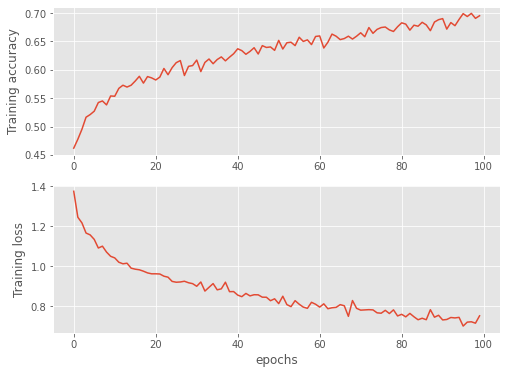

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history.history['accuracy']
loss = history.history['loss']
ax1.plot(acc, label=model)
ax2.plot(loss, label=model)
    
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Training loss')
ax2.set_xlabel('epochs')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.58      0.58        86
           1       0.38      0.20      0.26        70
           2       0.67      0.82      0.74       277
           3       0.52      0.51      0.51        71
           4       0.84      0.71      0.77       173

    accuracy                           0.66       677
   macro avg       0.60      0.56      0.57       677
weighted avg       0.66      0.66      0.65       677



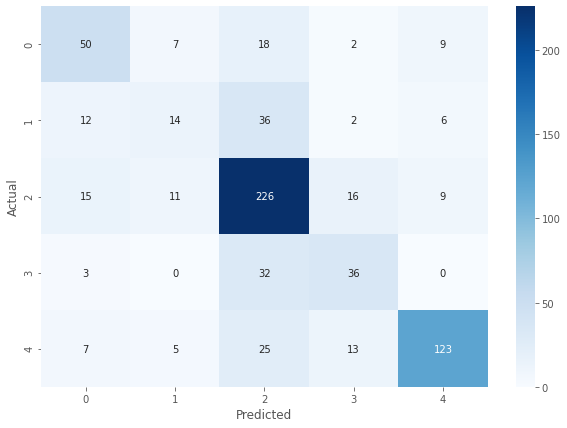

In [0]:
# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดล CNN 
print(classification_report(y_test_single, y_pred_single))

conf_mat = confusion_matrix(y_test_single, y_pred_single)
plt.figure(figsize = (10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels='0 1 2 3 4'.split(), yticklabels='0 1 2 3 4'.split(), cmap="Blues")
bottom, top = ax.get_ylim()
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [0]:
# LSTM

model = Sequential()
model.add(LSTM(32, input_shape=(X_2d_train.shape[1:]) ))


# model.add(Dropout(0.25))

# model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()

optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 4,901
Trainable params: 4,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit( X_2d_train, y_train, batch_size=16, validation_data=(X_2d_valid, y_valid), epochs=100)

Train on 2163 samples, validate on 541 samples
Epoch 1/100
2163/2163 [==============================] - 1s 284us/step - loss: 1.4749 - accuracy: 0.4045 - val_loss: 1.4195 - val_accuracy: 0.4104
Epoch 2/100
2163/2163 [==============================] - 0s 163us/step - loss: 1.3974 - accuracy: 0.4189 - val_loss: 1.3739 - val_accuracy: 0.4307
Epoch 3/100
2163/2163 [==============================] - 0s 158us/step - loss: 1.3689 - accuracy: 0.4286 - val_loss: 1.3674 - val_accuracy: 0.4455
Epoch 4/100
2163/2163 [==============================] - 0s 165us/step - loss: 1.3560 - accuracy: 0.4434 - val_loss: 1.3418 - val_accuracy: 0.4325
Epoch 5/100
2163/2163 [==============================] - 0s 163us/step - loss: 1.3338 - accuracy: 0.4498 - val_loss: 1.3247 - val_accuracy: 0.4344
Epoch 6/100
2163/2163 [==============================] - 0s 182us/step - loss: 1.3130 - accuracy: 0.4600 - val_loss: 1.3180 - val_accuracy: 0.4325
Epoch 7/100
2163/2163 [==============================] - 0s 159us/step 

In [0]:
# predict LSTM
y_prediction = model.predict(X_2d_test)
y_pred_single = [np.argmax(p) for p in y_prediction]
y_test_single = [np.argmax(p) for p in y_test]

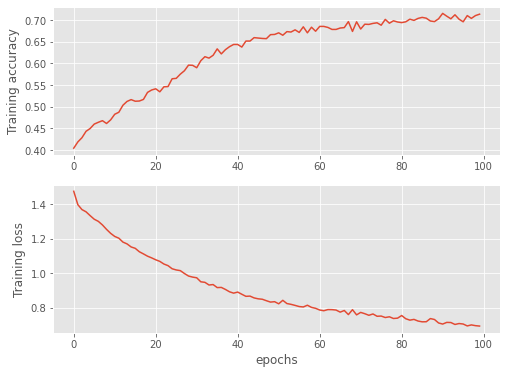

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history.history['accuracy']
loss = history.history['loss']
ax1.plot(acc, label=model)
ax2.plot(loss, label=model)
    
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Training loss')
ax2.set_xlabel('epochs')
#ax1.legend()
#ax2.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        86
           1       0.29      0.13      0.18        70
           2       0.65      0.74      0.69       277
           3       0.53      0.59      0.56        71
           4       0.78      0.72      0.75       173

    accuracy                           0.64       677
   macro avg       0.56      0.55      0.55       677
weighted avg       0.62      0.64      0.62       677



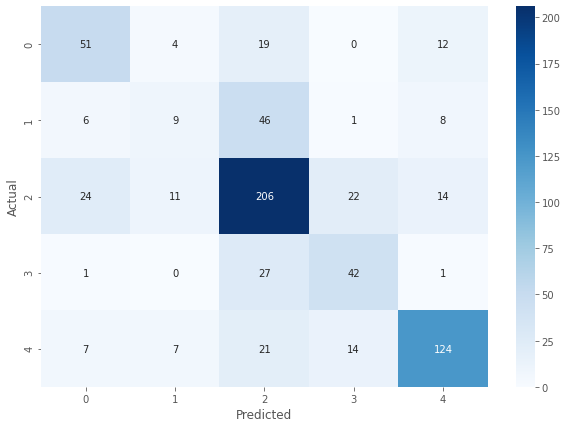

In [0]:
# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดล LSTM
print(classification_report(y_test_single, y_pred_single))

conf_mat = confusion_matrix(y_test_single, y_pred_single)
plt.figure(figsize = (10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels='0 1 2 3 4'.split(), yticklabels='0 1 2 3 4'.split(), cmap="Blues")
bottom, top = ax.get_ylim()
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# ตอนที่ 3 การทดลองการค้นหาพารามิเตอร์ที่ดีที่สุดสำหรับโมเดล

In [0]:
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# # สร้างโมเดลรูปแบบ cross validation

# seed = 42          # กำหนดเพื่อให้ random ได้ชุดข้อมูลเดียวกันในทุกครั้งที่รัน
# k = 5              # กำหนดจำนวนชุดข้อมูลย่อยที่จะถูกนำมาทำ StratifiedKFold Cross Validation
# skfold = StratifiedKFold(n_splits=k, shuffle = True, random_state=seed)

# # กำหนดรายการพารามิเตอร์ทั้งหมดที่ต้องการทดสอบหาค่าที่ดีที่สุดของโมเดล 

# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]
# optimizers = ['Adam','SGD']
# param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)


# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# best_cnn_model = KerasClassifier(build_fn=cnn_model(optimizer, 'categorical_crossentropy'))
# # best_lstm_model = KerasClassifier(build_fn=lstm_model(optimizer, 'categorical_crossentropy'))

In [0]:
# # ทำ cross validation หาค่าพารามิเตอร์ที่ดีที่สุด ใช้ cross validation (cv) เป็น StratifyKfold ที่กำหนดไว้ในตอนข้อ 3.1
# gsCV_cnn_model = GridSearchCV( estimator=best_cnn_model, param_grid=param_grid, n_jobs=2, cv=skfold, scoring='accuracy')
# gsCV_cnn_model.fit(X_train, y_train)

In [0]:
# gsCV_lstm_model = GridSearchCV( estimator=best_lstm_model, param_grid=param_grid, n_jobs=2, cv=skfold, scoring='accuracy')
# gsCV_lstm_model.fit(X_2d_train, y_2d_train)

In [0]:
def search_parameter(model):
    p = {
        # 'activation':['relu', 'sigmoid', 'tanh', 'softmax'],
         'optimizer': ['Adam', 'adadelta'],
         'losses': ['categorical_crossentropy'],
         'batch_size': [8, 16, 20, 40, 60, 80, 100],
         'epochs': [10, 50, 100]
         }

    def cnn_model(X_train, y_train, x_val, y_val, params):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(Flatten())
        model.add(Dense(128 , activation='relu' ))
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        out = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=[x_val, y_val], verbose=0)
        return out, model

    def lstm_model(X_train, y_train, x_val, y_val, params):
        model = Sequential()
        model.add(LSTM(32, input_shape=(X_train.shape[1:]) ))
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile( loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        out = model.fit( X_train, y_train, batch_size=params['batch_size'], validation_data=[x_val, y_val], epochs=params['epochs'], verbose=0)
        return out, model

    if model == 'cnn' :
      scan_object = ta.Scan(X_train, y_train, model=cnn_model, params=p, experiment_name='cnn', fraction_limit=0.1, x_val=X_valid, y_val=y_valid)
    else :
      scan_object = ta.Scan(X_2d_train, y_train, model=lstm_model, params=p, experiment_name='lstm', fraction_limit=0.1, x_val=X_2d_valid, y_val=y_valid)

    return scan_object

In [0]:
def cnn_model(optimizer, losses) :
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128 , activation='relu' ))
  model.add(Dense(y_train.shape[1], activation='sigmoid'))
  model.compile( loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
def lstm_model(optimizer, losses) :
  model = Sequential()
  model.add(LSTM(32, input_shape=(X_2d_train.shape[1:]) ))
  model.add(Dense(y_train.shape[1], activation='sigmoid'))
  model.compile( loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
def show_search_res(scan, model) :
  # use Scan object as input
  analyze_object = ta.Analyze(scan)
  print(analyze_object.data)
  print('=================================================')

  # get the highest result for any metric
  print('Low validate loss : ', analyze_object.high('val_accuracy'))
  print('=================================================')

  # get the round with the best result
  print('\nindex of best result :', analyze_object.rounds2high('val_accuracy'))
  print('=================================================')

  # evaluae with k fold
  e = ta.Evaluate(scan)
  model_evaluate = list()
  if model == 'lstm' :
    xx = X_2d_train
    yy = y_train
  else :
    xx = X_train
    yy = y_train
  for i in range(len(analyze_object.data)) :
    evaluate = e.evaluate(xx, yy, folds=10, metric='val_accuracy', task='multi_label', model_id=i)
    model_evaluate.append(np.array(evaluate).mean())
  print('evaluate with kfold', model_evaluate)
  print('=================================================')

  # get the best paramaters
  print('\nbest parameters :')
  print(analyze_object.best_params('val_accuracy', ['acc', 'loss', 'val_loss']))
  analyze_object.plot_line('val_accuracy')
  return analyze_object, model_evaluate


100%|██████████| 4/4 [01:01<00:00, 15.30s/it]


experiment_name                     cnn
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            03/30/20/06:48
x_shape                 (2163, 3, 4, 1)
y_shape                       (2163, 5)
dtype: object
   round_epochs  val_loss  ...                    losses  optimizer
0            10  1.316270  ...  categorical_crossentropy       Adam
1            50  1.010865  ...  categorical_crossentropy       Adam
2           100  0.860332  ...  categorical_crossentropy       Adam
3            10  1.169109  ...  categorical_crossentropy       Adam

[4 rows x 9 columns]
Low validate loss :  0.6506469249725342

index of best result : 2


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


evaluate with kfold [0.11613622881156505, 0.4688153053244834, 0.6201039375192072, 0.3640848097458648]

best parameters :
[[100 40 'Adam' 100 'categorical_crossentropy' 0.6527970433235168 0]
 [50 60 'Adam' 50 'categorical_crossentropy' 0.5640314221382141 1]
 [10 16 'Adam' 10 'categorical_crossentropy' 0.508090615272522 2]
 [10 60 'Adam' 10 'categorical_crossentropy' 0.41007858514785767 3]]


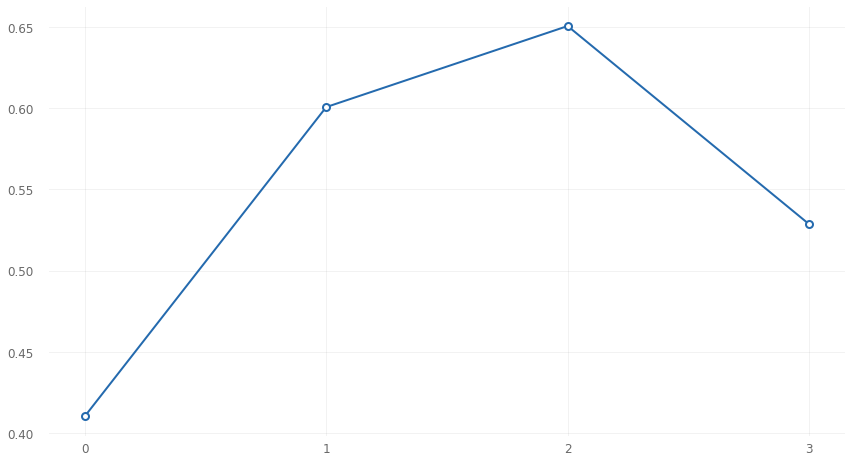

In [0]:
scan = search_parameter('cnn')
print(scan.details)
print('=================================================')
analyze_object_cnn, model_cnn_evaluate = show_search_res(scan, 'cnn')

100%|██████████| 4/4 [01:40<00:00, 25.03s/it]


experiment_name                    lstm
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            03/30/20/06:54
x_shape                    (2163, 3, 4)
y_shape                       (2163, 5)
dtype: object
   round_epochs  val_loss  ...                    losses  optimizer
0           100  0.877243  ...  categorical_crossentropy       Adam
1           100  0.859741  ...  categorical_crossentropy   adadelta
2           100  0.760143  ...  categorical_crossentropy       Adam
3            10  1.337980  ...  categorical_crossentropy   adadelta

[4 rows x 9 columns]
Low validate loss :  0.706099808216095

index of best result : 2
evaluate with kfold [0.6168751723390622, 0.607709605196705, 0.7229203790975777, 0.2372887444272178]

best parameters :
[[100 8 'Adam' 100 'categorical_crossent

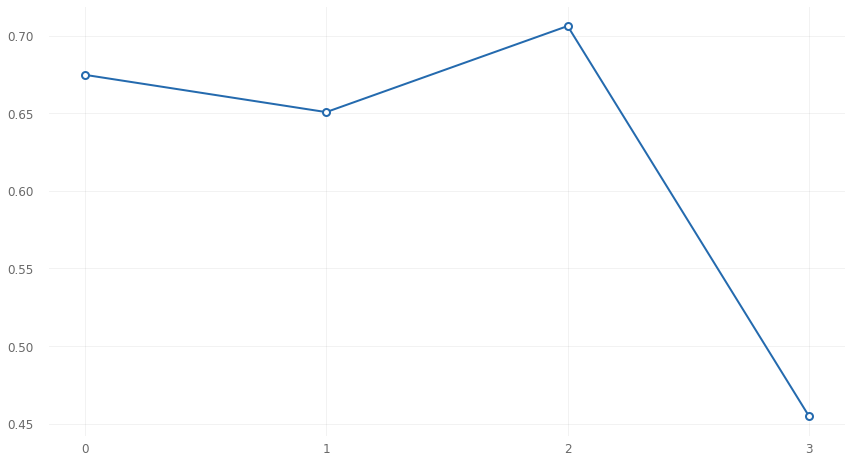

In [0]:
scan = search_parameter('lstm')
print(scan.details)
print('=================================================')
analyze_object_lstm, model_lstm_evaluate = show_search_res(scan, 'lstm')

In [0]:
cnn_best_params = analyze_object_cnn.data.iloc[analyze_object_cnn.rounds2high('val_accuracy'), :]
print('CNN best score : ', model_cnn_evaluate[analyze_object_cnn.rounds2high('val_accuracy')])
print('CNN best parameters : \n', cnn_best_params)

print('==================================')

lstm_best_params = analyze_object_lstm.data.iloc[analyze_object_lstm.rounds2high('val_accuracy'), :]
print('LSTM best score : ', model_lstm_evaluate[analyze_object_lstm.rounds2high('val_accuracy')])
print('LSTM best parameters : \n', lstm_best_params)


# save
cnn_best_params.to_csv(root_dir + '/cnn_best_params.csv')
lstm_best_params.to_csv(root_dir + '/lstm_best_params.csv')

CNN best score :  0.6201039375192072
CNN best parameters : 
 round_epochs                         100
val_loss                        0.860332
val_accuracy                    0.650647
loss                            0.837482
accuracy                        0.652797
batch_size                            40
epochs                               100
losses          categorical_crossentropy
optimizer                           Adam
NaN                                    2
Name: 2, dtype: object
LSTM best score :  0.7229203790975777
LSTM best parameters : 
 round_epochs                         100
val_loss                        0.760143
val_accuracy                      0.7061
loss                             0.59341
accuracy                        0.758206
batch_size                             8
epochs                               100
losses          categorical_crossentropy
optimizer                           Adam
NaN                                    2
Name: 2, dtype: object


In [0]:
model = cnn_model(cnn_best_params['optimizer'], cnn_best_params['losses'])
model.summary()
history = model.fit(X_train, y_train, batch_size=cnn_best_params['batch_size'], validation_data=(X_valid, y_valid), epochs=cnn_best_params['epochs'], verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2, 32)          128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 2, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 128)        

              precision    recall  f1-score   support

           0       0.65      0.50      0.57        86
           1       0.52      0.17      0.26        70
           2       0.61      0.82      0.70       277
           3       0.38      0.48      0.42        71
           4       0.78      0.58      0.66       173

    accuracy                           0.61       677
   macro avg       0.59      0.51      0.52       677
weighted avg       0.63      0.61      0.60       677



findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


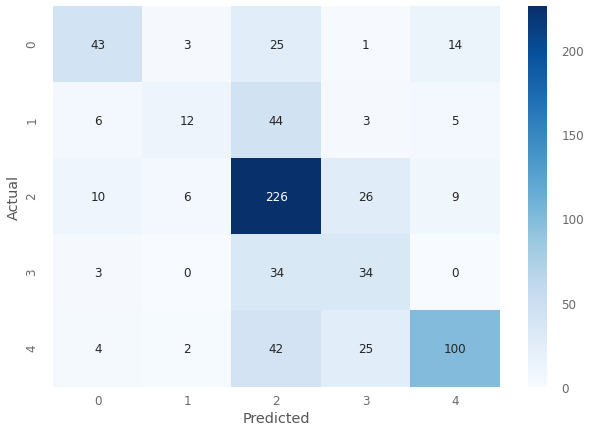

In [0]:
# ใช้โมเดลที่สอนจากพารามิเตอร์ที่ดีที่สุดมา predict ข้อมูล ชุด x_test
y_prediction = model.predict(X_test)
y_pred_single = [np.argmax(p) for p in y_prediction]
y_test_single=[np.argmax(p) for p in y_test]

# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดล CNN

print(classification_report(y_test_single, y_pred_single))

conf_mat = confusion_matrix(y_test_single, y_pred_single)
plt.figure(figsize = (10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels='0 1 2 3 4'.split(), yticklabels='0 1 2 3 4'.split(), cmap="Blues")
bottom, top = ax.get_ylim()
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [0]:
model = lstm_model(lstm_best_params['optimizer'], lstm_best_params['losses'])
model.summary()
history = model.fit(X_2d_train, y_train, batch_size=lstm_best_params['batch_size'], validation_data=(X_2d_valid, y_valid), epochs=lstm_best_params['epochs'], verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 4,901
Trainable params: 4,901
Non-trainable params: 0
_________________________________________________________________
Train on 2163 samples, validate on 541 samples
Epoch 1/100
2163/2163 [==============================] - 1s 459us/step - loss: 1.4976 - accuracy: 0.4022 - val_loss: 1.4404 - val_accuracy: 0.4104
Epoch 2/100
2163/2163 [==============================] - 1s 332us/step - loss: 1.4307 - accuracy: 0.4101 - val_loss: 1.4194 - val_accuracy: 0.4104
Epoch 3/100
2163/2163 [==============================] - 1s 326us/step - loss: 1.3967 - accuracy: 0.4110 - val_loss: 1.3883 - val_accuracy: 0.4251
Epoch 4/100
2163/2163 [===

              precision    recall  f1-score   support

           0       0.45      0.52      0.49        86
           1       0.30      0.04      0.07        70
           2       0.61      0.77      0.68       277
           3       0.82      0.39      0.53        71
           4       0.70      0.76      0.73       173

    accuracy                           0.62       677
   macro avg       0.58      0.50      0.50       677
weighted avg       0.61      0.62      0.59       677



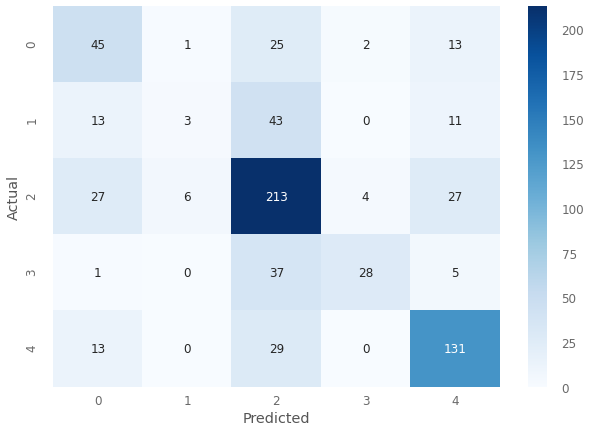

In [0]:
y_prediction = model.predict(X_2d_test)
y_pred_single = [np.argmax(p) for p in y_prediction]
y_test_single = [np.argmax(p) for p in y_test]

# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดล CNN

print(classification_report(y_test_single, y_pred_single))

conf_mat = confusion_matrix(y_test_single, y_pred_single)
plt.figure(figsize = (10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels='0 1 2 3 4'.split(), yticklabels='0 1 2 3 4'.split(), cmap="Blues")
bottom, top = ax.get_ylim()
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [0]:
lstm_df = pd.DataFrame(lstm_best_params).transpose()
cnn_df = pd.DataFrame(cnn_best_params).transpose()
params_df = pd.concat([cnn_df, lstm_df])
params_df.reset_index(drop=True, inplace=True)
params_df['model'] = ['CNN', 'LSTM']
params_df.set_index('model', inplace=True)
params_df = params_df[['epochs', 'batch_size', 'losses', 'optimizer']]
params_df

,epochs,batch_size,losses,optimizer
model,,,,
CNN,100,40,categorical_crossentropy,Adam
LSTM,100,8,categorical_crossentropy,Adam


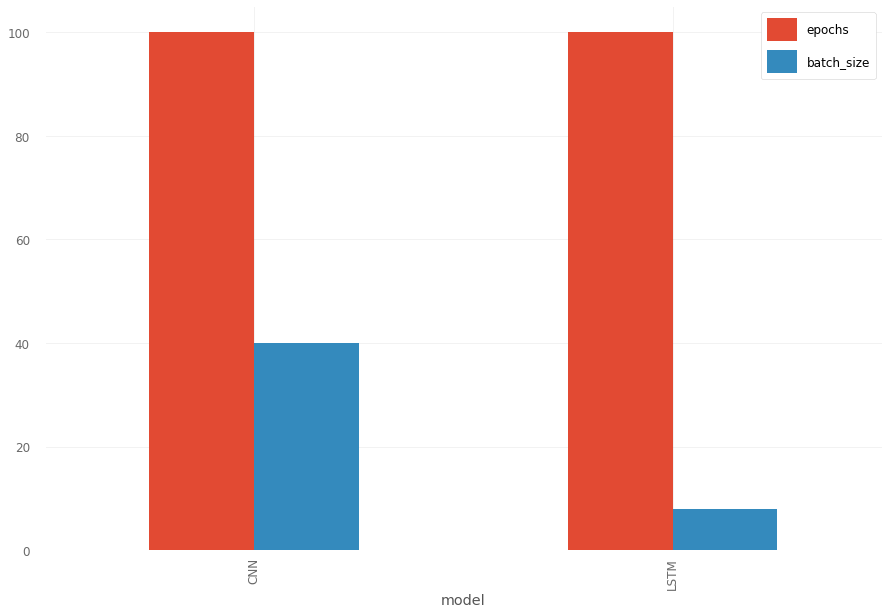

In [0]:
params_df.plot.bar(figsize=(15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff32ac36d30>],
      dtype=object)

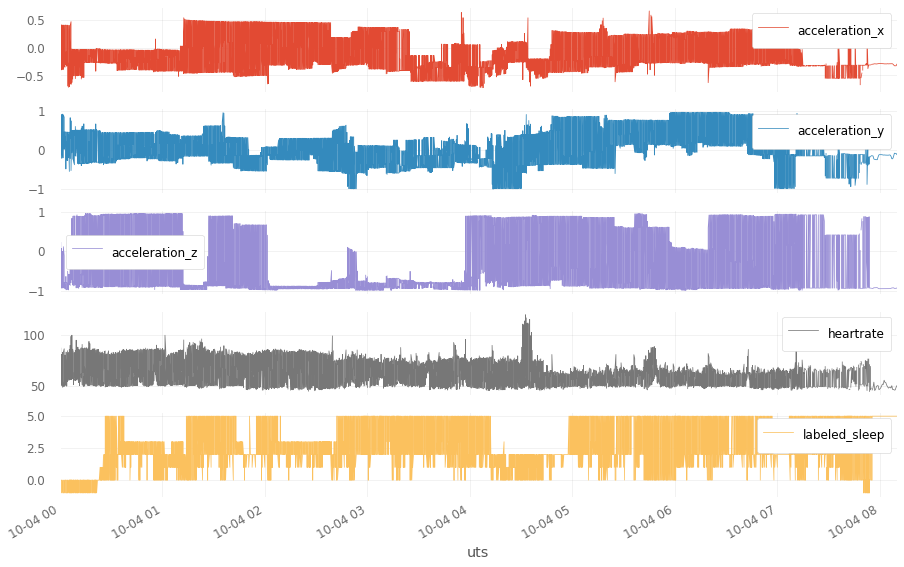

In [0]:
# visual เปรียบเทียบข้อมูลก่อน Cleaning

before_clean_df[before_clean_df.columns].plot(subplots=True, layout=(5, 1), figsize=(15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff32abc4f28>],
      dtype=object)

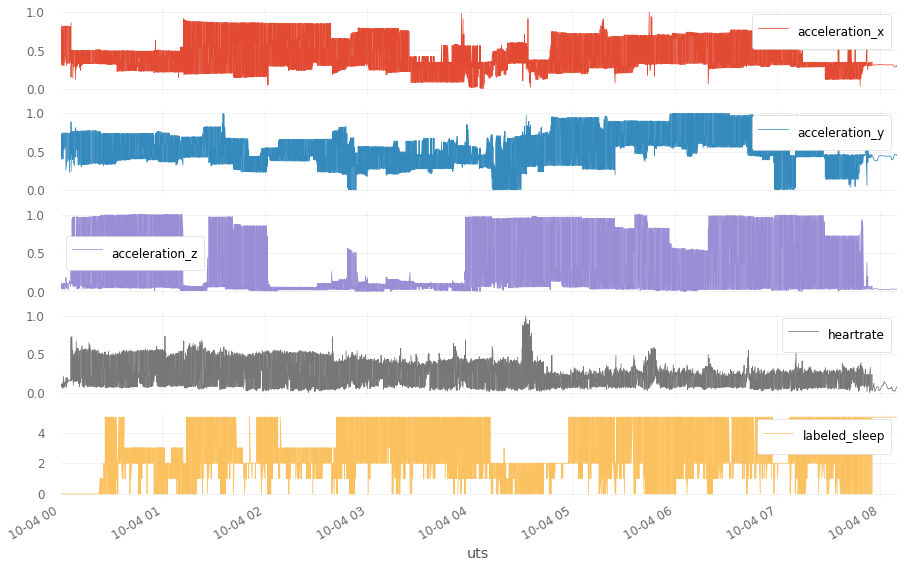

In [0]:

# visual เปรียบเทียบข้อมูลหลัง Cleaning
df_all[df_all.columns].plot(subplots=True, layout=(5, 1), figsize=(15,10))
